In [1]:
# %load_ext autoreload
# %autoreload 2

import torchvision
import numpy as np
from torch.utils import data
from matplotlib import pyplot as plt
import torchvision.transforms.v2 as transforms
import torch
from encoder import CenternetEncoder
from visualizer import get_image_with_bboxes
from model import input_height, input_width, ModelBuilder
from dataset import Dataset


print("GPU is available: ", torch.cuda.is_available())

plt.rcParams['figure.figsize'] = (12.0, 8.0)


GPU is available:  False


In [2]:
dataset_val = torchvision.datasets.VOCDetection(root="VOC", year='2007', image_set="val", download=False)
dataset_val = torchvision.datasets.wrap_dataset_for_transforms_v2(dataset_val)

# these 10 pictures from the VOC dataset were randomly selected for model training
trainingdata_indices = torch.tensor([955, 1025, 219, 66, 1344, 222, 865, 2317, 86, 1409])

print(len(dataset_val))

2510


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = ModelBuilder(alpha=0.25).to(device)
model.load_state_dict(torch.load("./trained_model", weights_only=True))

loss_dict = {}


<All keys matched successfully>

{'boxes': BoundingBoxes([[ 33, 109, 260, 334],
               [  1, 165, 259, 334],
               [323, 161, 353, 220],
               [323, 164, 500, 334],
               [309, 170, 461, 334]], format=BoundingBoxFormat.XYXY, canvas_size=(334, 500)), 'labels': tensor([15, 18,  9,  9, 15])}


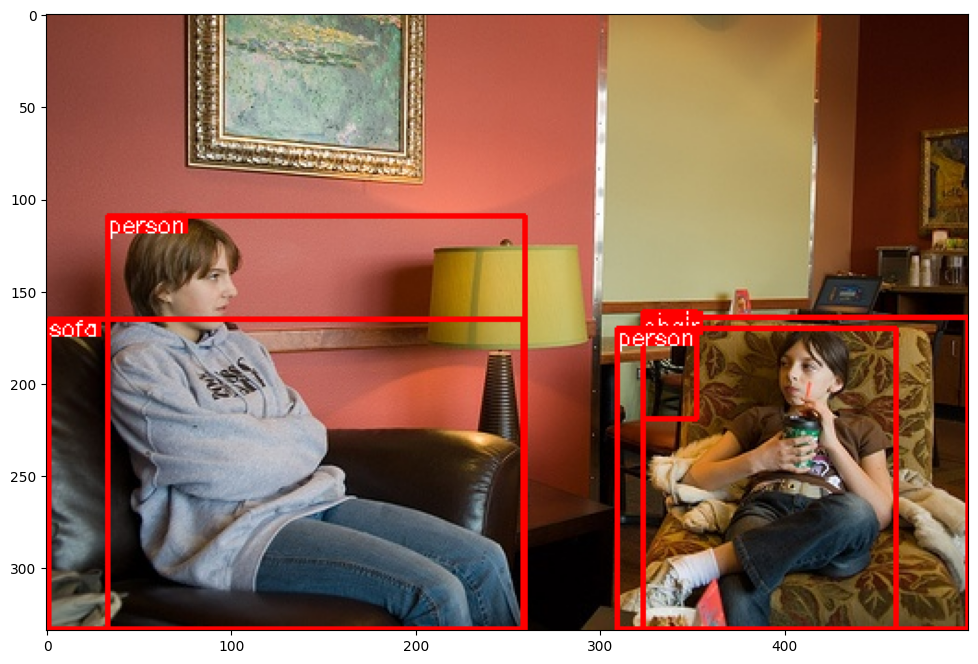

In [4]:
# just to explore heatmap for some specific image used in model training

image_index = 5  # 0 (car) is also a good choice

img, lbl = dataset_val[trainingdata_indices[image_index]]
print(lbl)

# 
image_with_boxes = get_image_with_bboxes(img, lbl['boxes'], lbl['labels'])
plt.imshow(image_with_boxes)

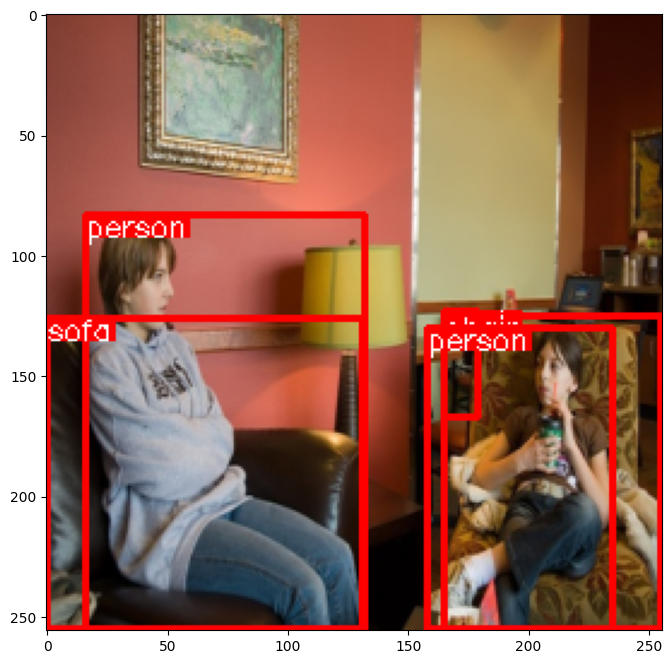

In [5]:
transform_resize = transforms.Compose([transforms.Resize(size=(input_width, input_height))])
img_transformed, bboxes, labels = transform_resize(img, lbl['boxes'], lbl['labels'])

image_with_boxes = get_image_with_bboxes(img_transformed,  bboxes, labels)
plt.imshow(image_with_boxes)

In [6]:
encoder = CenternetEncoder(input_height, input_width)
lbl_encoded = encoder(bboxes, labels)

for i in range(20):
    hm_chosen_current = lbl_encoded[..., i]
    print(f'i = {i + 1}; np.amax(hm_chosen) = {np.amax(hm_chosen_current)}')
print()

down_ratio = 4
i = 1; np.amax(hm_chosen) = 0.0
i = 2; np.amax(hm_chosen) = 0.0
i = 3; np.amax(hm_chosen) = 0.0
i = 4; np.amax(hm_chosen) = 0.0
i = 5; np.amax(hm_chosen) = 0.0
i = 6; np.amax(hm_chosen) = 0.0
i = 7; np.amax(hm_chosen) = 0.0
i = 8; np.amax(hm_chosen) = 0.0
i = 9; np.amax(hm_chosen) = 1.0
i = 10; np.amax(hm_chosen) = 0.0
i = 11; np.amax(hm_chosen) = 0.0
i = 12; np.amax(hm_chosen) = 0.0
i = 13; np.amax(hm_chosen) = 0.0
i = 14; np.amax(hm_chosen) = 0.0
i = 15; np.amax(hm_chosen) = 1.0
i = 16; np.amax(hm_chosen) = 0.0
i = 17; np.amax(hm_chosen) = 0.0
i = 18; np.amax(hm_chosen) = 1.0
i = 19; np.amax(hm_chosen) = 0.0
i = 20; np.amax(hm_chosen) = 0.0



i = 15; np.amax(hm_chosen) = 1.0

rect center: [168  76]
coors [ 16.  83. 133. 256.]

rect center: [192 196]
coors [158. 130. 236. 256.]



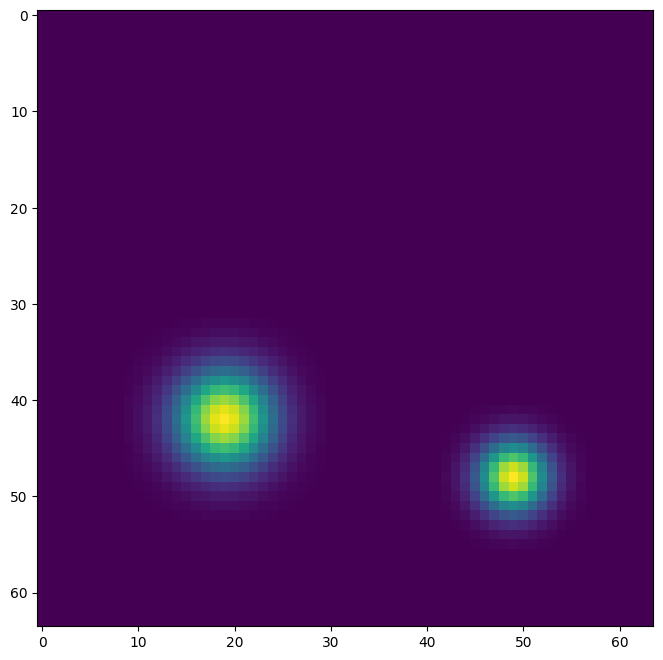

In [7]:
i = lbl['labels'][0]  # corresponds to 'person'
hm_chosen = lbl_encoded[..., i - 1]
print(f'i = {i}; np.amax(hm_chosen) = {np.amax(hm_chosen)}')
print()

ind_max = np.argwhere(hm_chosen == np.amax(hm_chosen))
for ind in ind_max:
    print("rect center:", ind * 4)
    print("coors", lbl_encoded[..., 20:][ind[0], ind[1]])
    print()

plt.imshow(lbl_encoded[..., lbl['labels'][0]-1])

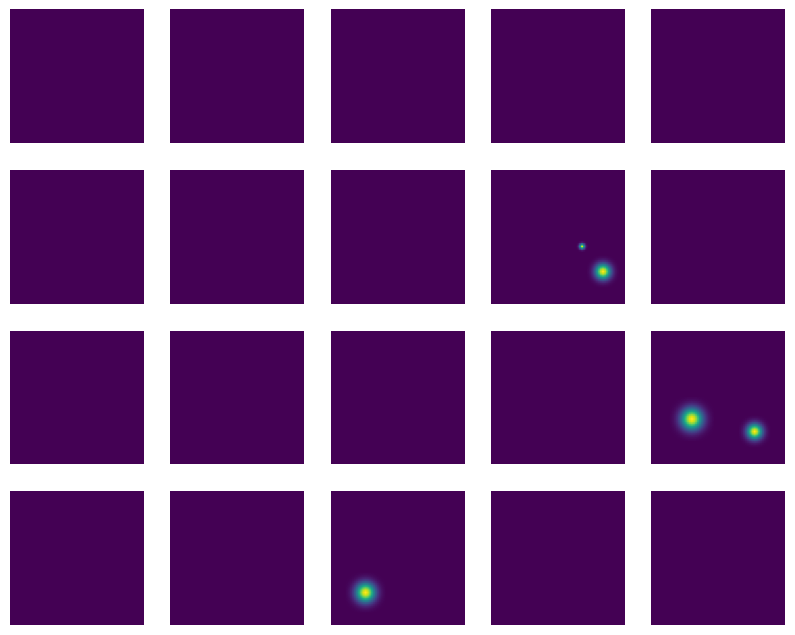

In [8]:
plt.rcParams['figure.figsize'] = (10.0, 8.0)

for y in range(5):
    for i in range(4):
        plt_idx = i + y * 4 + 1
        plt.subplot(4, 5, plt_idx)
        plt.imshow(lbl_encoded[...,plt_idx-1])
        plt.axis('off')
plt.show()

There are 12 persons in dataset


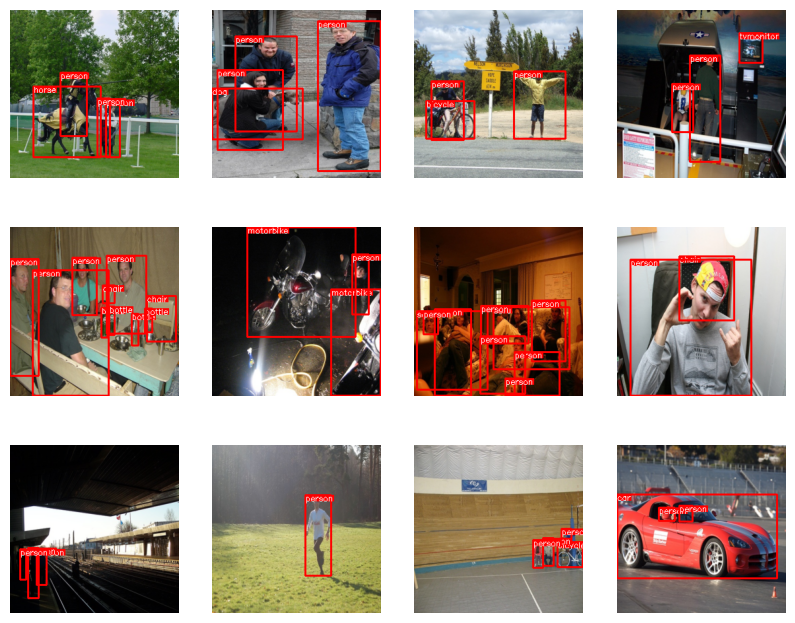

In [9]:
# Filter the entire VOC dataset to get 12 images containing persons. Label = 15
number_of_persons = 12
person_label = 15

person_images = []
testdata_indexes = []

for index, (img, lbl) in enumerate(dataset_val):
    if person_label in lbl['labels']:
        testdata_indexes.append(index)
        person_images.append({'index': index, 'image': img, 'lbl': lbl})
    if len(testdata_indexes) == number_of_persons:
        break

print(f'There are {len(person_images)} persons in dataset')

# Visualize first 10 persons from the dataset.
# They form my test data.
for y in range(4):
    for i in range(3):
        plt_idx = i + y * 3 + 1
        plt.subplot(3, 4, plt_idx)

        img_transformed, bboxes, labels = transform_resize(
            person_images[plt_idx-1]['image'], 
            person_images[plt_idx-1]['lbl']['boxes'], 
            person_images[plt_idx-1]['lbl']['labels']
        )

        image_with_boxes = get_image_with_bboxes(img_transformed, bboxes, labels)
        plt.imshow(image_with_boxes)
        
        plt.axis('off')
plt.show()

In [10]:
model.eval()

# I cannot get predictions without train(True)
model.train(True)

ModelBuilder(
  (backbone): Backbone(
    (layer1): Sequential(
      (conv_1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_1): ReLU()
    )
    (layer2): Sequential(
      (conv_2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_2): ReLU()
      (pool_2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (layer3): Sequential(
      (conv_3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_3): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (relu_3): ReLU()
    )
    (layer4): Sequential(
      (conv_4): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_4): BatchNorm2d(32, eps=0.001, momentum=0.01, affine=True,

In [11]:
transform = transforms.Compose([
    transforms.Resize(size=(input_width, input_height)),
    transforms.ToImage(),
    transforms.ToDtype(torch.float32, scale=True),
])
torch_dataset = Dataset(dataset=dataset_val, transformation=transform, encoder=encoder)

training_data = torch.utils.data.Subset(torch_dataset, trainingdata_indices)
test_data = torch.utils.data.Subset(torch_dataset, testdata_indexes)

# comment this line when you need calculations on really test data
test_data = training_data

# Here I am getting the loss for test data received with trained model

# todo (AA): I don't completely understand what this prediction contain
batch_generator = torch.utils.data.DataLoader(
    test_data,
    num_workers=4,
    batch_size=12
)
for input_data, gt_data in batch_generator:
    input_contiguous = input_data.to(device).contiguous()
    gt_data_device = gt_data.to(device)
    # result = model.forward(img_reshaped.to(device), gt=gt_data_device)

    result = model.forward(input_contiguous, gt=gt_data_device)
    print(result['loss'])

    # it gives the same result as above
    # result = model(input_contiguous)
    # print(model.loss(gt_data_device, result)['loss'])

tensor(0.9567, grad_fn=<AddBackward0>)
